## Week 8: Fitting part 2
<hr style="height: 3.0px"/>

Let's take a look at a more advanced fitting package for this week.  
    
**Part 2**:  new package: `lmfit` https://lmfit.github.io/lmfit-py/  
>    1. We will first learn to install a new package to our Python installation  
>    2. Application: Cystallization Kinetics of an ionic liquid (Royal Society of Chemistry Advances >(RSC Adv.), 2014, vol. 4, p. 22277)  
>    3. Fitting (deconvolution) of two overlapping peaks in calorimetry data  

Much of this lesson is taken from:
https://chrisostrouchov.com/post/peak_fit_xrd_python/   

The first thing you need to do is install the new package "lmfit" as explained in the short video below. If the video below isn't working, you can go directly to the youtube link: https://youtu.be/R8FX2G8m6XM
    

In [2]:
from IPython.display import HTML, IFrame

# Youtube
#HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/R8FX2G8m6XM?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')
IFrame("https://www.youtube.com/embed/R8FX2G8m6XM",870,613)

In [1]:
########  The lmfit import will not work until you install lmfit as described above. 

# import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy import optimize, signal

from lmfit import models, Model, Parameters

### Let's generate some overlapping peak data simulating Differential Scanning Calorimetry (DSC) data.  The presence of a peak indicates the formation of crystals within the polymer.  Overlapping peaks correspond to two different crystalline structures forming.  
#### DSC will be discussed in your Polymer engineering course MSE 4554.  The kinetics of crystalization was discussed briefly in MSE 2044 and follows the avrami equation.  

> Aside: These are the "S" shaped curves we looked at in MSE 2044 Phase Transformations and in last weeks lesson.  The avrami curve has the form 

We are going to use a gaussian peak function to generate our "simulated" data.  We will look at real data for homework.  The idea here is learn how to fit overlapping peaks with "ideal" data and then we can apply this to real data.    

Gaussian peak function: 
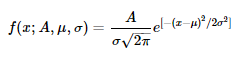

In [2]:
# The Gaussian function above is: A/(σ*np.sqrt(2*np.pi)) * np.exp(-1/2*((x - μ) / σ)**2)
# So let's write this as a python function called, g.  
def g(x, A, μ, σ):
    return A/(σ*np.sqrt(2*np.pi)) * np.exp(-1/2*((x - μ) / σ)**2)
# A is the amplitude
# μ is the peak mean 
# σ is the standard deviation

> Aside:  to get greek letters for variable names as above type for example "\sigma" and then press tab key

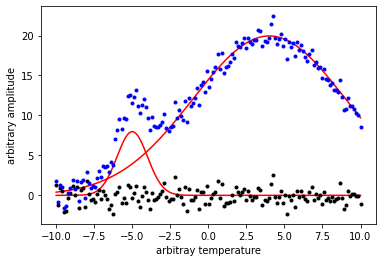

In [3]:
# Generate some data for two peaks.
# here we define the parameters [A,μ,σ] for the two peaks
g_0 = [250.0, 4.0, 5.0] # [A,μ,σ] peak centered at 4
g_1 = [20.0, -5.0, 1.0] # [A,μ,σ] peak centered at -5
n = 150 # number of points
x = np.linspace(-10, 10, n) #generate our x data
noise=np.random.randn(n) #generate some noise to add to our peaks
y = g(x, *g_0) + g(x, *g_1) + noise #generating some data with random noise
# the star operator used in the above line is discussed below

plt.plot(x, g(x, *g_0), 'r-'); #peak at 4
plt.plot(x, g(x, *g_1), 'r-'); #peak at -5
plt.plot(x, noise, 'k.'); #noise
plt.plot(x, y, 'b.'); #sum of the above
plt.ylabel('arbitrary amplitude');
plt.xlabel('arbitray temperature');

>I used the star operator above for example \*g_0 as a shortcut.  The above \*g_0 places the values 250.0, 4.0, 5.0 into our function call **without** the square brackets.  The following are equivalent: 
```Python
g(x, *g_0) or 
g(x, g_0[0], g_0[1], g_0[2])
g(x, 250.0, 4.0, 5.0)  
```

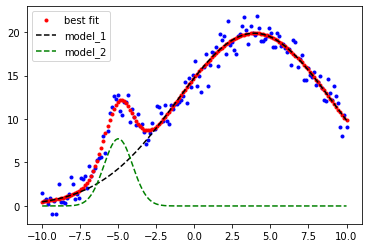

{'m2_A': 18.218834993751805, 'm2_μ': -4.994850732374022, 'm2_σ': 0.9394826139214512, 'm1_A': 254.45452440319823, 'm1_μ': 3.9455904161188933, 'm1_σ': 5.1090621327043}


In [4]:
# Follow these steps to use the lmfit package 

# Our x,y data defined: 

g_0 = [250.0, 4.0, 5.0] # [A,μ,σ] peak centered at 4
g_1 = [20.0, -5.0, 1.0] # [A,μ,σ] peak centered at -5
x = np.linspace(-10, 10, 150) #generate our x data
noise=np.random.randn(150) #generate noise - must have the same number of pts as x (150)
y = g(x, *g_0) + g(x, *g_1) + noise #generate our y-data

# when using a function more than once it is useful to define a prefix to separate variables
# for example, the amplitude in model_1 will now be called m1_A
# likewise in model_2 it will be m2_A

def g(x, A, μ, σ):
    return A/(σ*np.sqrt(2*np.pi)) * np.exp(-1/2*((x - μ) / σ)**2)

model_1 = Model(g, prefix='m1_') # g is the function we defined above
model_2 = Model(g, prefix='m2_') # using the same function but changing prefix
model = model_1 + model_2 # our fitting model is the sum of the two

# now we help the fitting process by giving starting values and bounds on our parameters
params = Parameters()
# parameters given as: (NAME, VALUE, VARY?, MIN,  MAX,  EXPR,  BRUTE_STEP)
params.add_many(('m1_A', 3, True, None, None, None, None),
                ('m1_μ', 5, True, None, None, None, None),
                ('m1_σ', 1, True, None, None, None, None),
                ('m2_A', 1, True, None, None, None, None),
                ('m2_μ', -3, True, None, None, None, None),
                ('m2_σ', 1, True, None, None, None, None))

result = model.fit(y, params, x=x) #now we perform the fit to our x & y data with the given params
comps = result.eval_components() #this separates the results into the two components model_1 and model_2

plt.plot(x, y, 'b.') #our x,y data blue dots
plt.plot(x, result.best_fit, 'r.', label='best fit') # our overall fit red line
plt.plot(x, comps['m1_'], 'k--', label='model_1') # peak 1 fit black dashed
plt.plot(x, comps['m2_'], 'g--', label='model_2') # peak 2 fit green dashed
plt.legend(loc='best')
plt.show()

#print(result.fit_report())
print(result.best_values)


In [9]:
print(result.fit_report())

[[Model]]
    (Model(g, prefix='m1_') + Model(g, prefix='m2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 219
    # data points      = 150
    # variables        = 6
    chi-square         = 168.119110
    reduced chi-square = 1.16749382
    Akaike info crit   = 29.1056131
    Bayesian info crit = 47.1694249
[[Variables]]
    m1_A:  20.5094687 +/- 1.38956215 (6.78%) (init = 3)
    m1_μ: -4.98153048 +/- 0.05330214 (1.07%) (init = 5)
    m1_σ:  1.01114877 +/- 0.06127536 (6.06%) (init = 1)
    m2_A:  251.656602 +/- 3.27257769 (1.30%) (init = 1)
    m2_μ:  4.02563034 +/- 0.05689715 (1.41%) (init = -3)
    m2_σ:  4.91034624 +/- 0.08322341 (1.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m2_A, m2_σ) = 0.852
    C(m1_A, m1_σ) = 0.717
    C(m1_A, m2_σ) = -0.673
    C(m1_A, m2_A) = -0.628
    C(m1_σ, m2_σ) = -0.457
    C(m1_σ, m2_A) = -0.435
    C(m1_A, m2_μ) = 0.256
    C(m1_σ, m2_μ) = 0.197
    C(m1_μ, m2_A) = -0.144
    C(m1_A

## So that is not looking so good!  Let's tweak our params to see if we can help the fit. 

#### Below I reduced my "help"  by only giving initial values.  I think my initial guess for the amplitudes was off enough that my constraints we too tight on the other variables.  

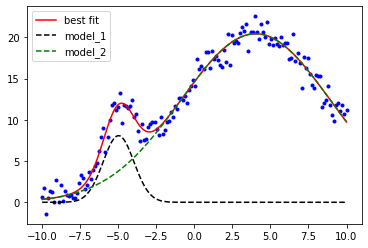

{'m2_A': 251.65660225248678, 'm2_μ': 4.025630338361899, 'm2_σ': 4.9103462368772846, 'm1_A': 20.509468747372058, 'm1_μ': -4.981530483096052, 'm1_σ': 1.0111487688184846}


In [6]:
params = Parameters()
#parameters given as: (NAME, VALUE, VARY, MIN,  MAX,  EXPR,  BRUTE_STEP)
params.add_many(('m1_A', 3, True, None, None, None, None),
                ('m1_μ', 5, True, None, None, None, None),
                ('m1_σ', 1, True, None, None, None, None),
                ('m2_A', 1, True, None, None, None, None),
                ('m2_μ', -3, True, None, None, None, None),
                ('m2_σ', 1, True, None, None, None, None))

result = model.fit(y, params, x=x) #now we perform the fit to our x & y data with the given params
comps = result.eval_components() #this separates the results into the two components model_1 and model_2

plt.plot(x, y, 'b.')
plt.plot(x, result.best_fit, 'r-', label='best fit') # sum of peak 1 and peak 2 fits
plt.plot(x, comps['m1_'], 'k--', label='model_1') # peak 1 fit
plt.plot(x, comps['m2_'], 'g--', label='model_2') # peak 2 fit
plt.legend(loc='best')
plt.show()

#print(result.fit_report())
print(result.best_values)

In [19]:
# recall g(x,A,μ,σ) and using the m1_A, m1_μ, and m1_σ printed in the previous cell
g(10, 254.2, 3.95, 5.108) # here is the y value for peak 1 (black dashed) at an x position of 10

9.844899900900574

**Now we have a nice fit!**

#### Let's look at how to use our fit parameters to plot the gaussian function.  The fit parameters are found in variable "result" by asking for the best values, i.e. result.best_values  

In [13]:
vals=result.best_values
print(vals) #notice values are returned as a dictionary
#to get a single value use the "key" for example
vals['m2_μ'] # using key m2_μ

{'m2_A': 21.31595607776833, 'm2_μ': -5.057999482178919, 'm2_σ': 0.9873979083058191, 'm1_A': 247.62210351292225, 'm1_μ': 4.016457262826163, 'm1_σ': 4.884984882973075}


-5.057999482178919

In [21]:
# or to get a list of just values of the dictionary
list(vals.values())

[19.37669981013322,
 -5.0654321127960795,
 0.9091247689204824,
 254.23058975084655,
 3.951672635141451,
 5.1084799673977095]

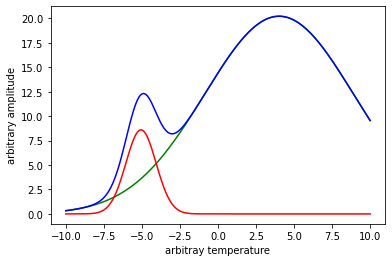

In [16]:
n = 150 # number of points
x = np.linspace(-10, 10, n) #generate our x data
# recall our function g() has 4 params in this order g(x, A, μ, σ)
y1=g(x, vals['m1_A'], vals['m1_μ'],vals['m1_σ']) 
y2=g(x, vals['m2_A'], vals['m2_μ'],vals['m2_σ'])
ysum= y1+y2

plt.plot(x, y1, 'g-'); 
plt.plot(x, y2, 'r-'); 
plt.plot(x, ysum, 'b-'); 
plt.ylabel('arbitrary amplitude');
plt.xlabel('arbitray temperature');

In [15]:
g(-5, vals['m1_A'], vals['m1_μ'],vals['m1_σ'])

3.6818078938517433

<hr style="height: 3px" \> 

# So that's the idea... now you try it.  
<hr style="height: 3px" \>

#### Now you are going to fit real data so you will need to use our `selectdata()` and `cal()` functions to get the data from the plots below.  Then you will fit this set of data.  

<hr style="height:1px"\>

**Problem 1:** reproduce the data below.  You will need all three curves.  The green (thick) curve is the measured data from DSC. Let's call this **"dsc_data"**.  The peaks labeled P1 and P2 are the fitted curves found by the authors. Let's call these **"p1_auth_data"** and **"p2_auth_data"**.  
<hr style="height:1px"\>

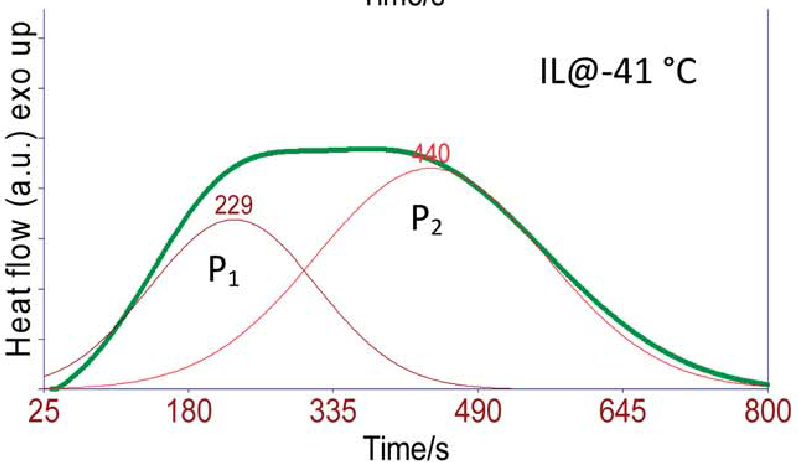

In [ ]:
def g(x, A, μ, σ):
    return A/(σ*np.sqrt(2*np.pi)) * np.exp(-1/2*((x - μ) / σ)**2)

model = Model(g) # g is the function we defined above
# now we help the fitting process by giving starting values and bounds on our parameters
params = Parameters()
# parameters given as: (NAME, VALUE, VARY?, MIN,  MAX,  EXPR,  BRUTE_STEP)
params.add_many(('A', 1, True, None, None, None, None),
                ('μ', 200, True, None, None, None, None),
                ('σ', 100, True, None, None, None, None))

# fix these lines below for your data set
x = "p1 cal x data"
y = "p1 cal y data"


result_p1 = model.fit(y, params, x=x) #now we perform the fit to our x & y data with the given params

plt.plot(x, y, 'b.') #our x,y data blue dots
plt.plot(x, result_p1.best_fit, 'r.', label='best fit') # our overall fit red line
plt.legend(loc='best')
plt.show()

#print(result.fit_report())
print(result.best_values)


<hr style="height:1px"\>

**Problem 2:** Fit the three data sets (dsc_data, p1_auth_data, and p2_auth_data) you just created using the Gauassian function, g, as done in the lesson.  The fit for `fit_dsc` will require two peaks as in the lesson.  The fits for `p1_auth_data` and `p2_auth_data` will only require you to use one peak for the fitting.  Refer to these as "*fit_dsc*", "*fit_p1_auth*" and "*fit_p2_auth*".   Plot each fit along with your data sets to ensure an adequate fit when comparing `dsc_data` to `fit_dsc`. 

That is, plot `dsc_data`, `p1_auth_data`, `p2_auth_data`, `fit_dsc`, `fit_p1_auth`, and `fit_p2_auth` all on one plot.    
<hr style="height:1px"\>

<hr style="height:1px"\>

**Problem 3:**  
1. Take your fits to P1 (fit_p1_auth) and P2 (fit_p2_auth) and add them together. You can do this by placing your fit parameters back into the g() function and summing, i.e. g(x, *p1 params*) + g(x, *p2 params*).  This is then the fit that the authors got to the overall curve.  
2. Plot the author's fit that you just found along with the overall data curve (dsc_data) and add your your fit (fit_dsc) to this plot.  How does your fit compare to the author's fit?  
3. Separate your overall fit (fit_dsc) into its two components (peaks).  Plot your two components (```comps['m1_']``` and ```comps['m2_']``` if you used the same prefix I did in the lesson) along with the author's P1 (fit_p1_auth) and P2 (fit_p2_auth).  How do these compare?
4.  If the area under the curve P1 and P2 represent the relative amounts of each phase 1 and 2, do your results suggest an increase or decrease in the relative amount of P1/P2.  You do not need to calculate anything here.  Just eyeball it. 

<hr style="height:1px"\>

Now there really isn't any reason to assume a gaussian profile for the DSC data as the authors in this paper have done.  In fact, we expect the kinetics of crystallization to follow avrami kinetics.  These are the "S" shaped curves we looked at in MSE 2044 Phase Transformations and in last weeks lesson.  The avrami curve has the form 

The peak in the DSC data should just be the derivative of the avrami equation.  

Derivative of Avrami

# $$Y'= k n t^{n-1} e^{-k t^n}$$

The above equation is given in normalized form below, i.e. the height = 1 and peak position = 1

# $$Y'(normalized) = e^{-\frac{(n-1) \left(t^n-1\right)}{n}} t^{n-1}$$

So to fit to an arbitrary amplitude, A, and peak position, B we could write: 

## $$\text{A } e^{-\frac{(\text{n}-1) \left(\left(\frac{t}{\text{B}}\right)^{\text{n}}-1\right)}{\text{n}}} \left(\frac{t}{\text{B}}\right)^{\text{n}-1}$$


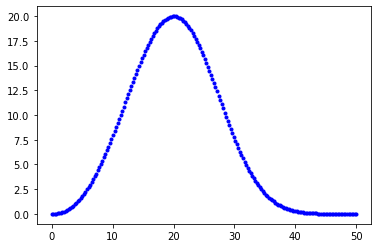

In [23]:
# Avrami peak function as derived above: 
# where A = amplitude, B = peak position, n = avrami fitting parameter
def pAvram(x, A, B, n):
    return A*((x/B)**(n-1))*np.exp(-((n-1)*(((x/B)**n)-1))/n)

x=np.linspace(0, 50, 200)
y=pAvram(x,20,20,3.23)

plt.plot(x, y, 'b.');

<hr style="height:1px"\>

**Problem 4:**  
1. Refit the dsc_data now using the pAvram function we just developed.  
2. Compare this fit to the author's fit and our gaussian fit.  Which fit is the best by eye?  
3. Plot the components of this avrami fit compared to the author's fit.  How do the peaks P1 and P2 compare?  How about the ratio of P1/P2.  

<hr style="height:1px"\>